In [ ]:
%pylab inline
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
from jax.scipy.ndimage import map_coordinates
import h5py
'unset XLA_FLAGS'

from jax.config import config
config.update("jax_enable_x64", True)


import cmasher as cmr

Populating the interactive namespace from numpy and matplotlib


/gpfslocalsup/pub/anaconda-py3/2021.05/envs/tensorflow-2.7.0+py3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.8) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


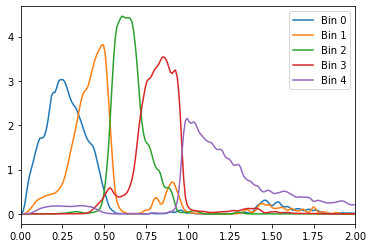

In [ ]:
# Reading the DC2 tomographic bins into redshift distribution objects
with h5py.File("shear_photoz_stack.hdf5") as f:
    group = f["n_of_z"]
    # Read the z grid
    source = group["source"]
    z_shear = source['z'][::]
    # Read the true n(z)
    nz_shear = [jc.redshift.kde_nz(z_shear,  
                                   source[f"bin_{i}"][:], 
                                   bw=0.01, zmax=2.5) for i in range(5)] 
for i in range(len(nz_shear)):
  plot(z_shear, nz_shear[i](z_shear),  color='C%d'%i, label="Bin %d"%i)
legend()
xlim(0,2);

In [3]:
lognormal_params = np.loadtxt('lognormal_shift.csv', skiprows=1, delimiter=',').reshape([8,8,3])

In [4]:
#Here we add the code that interpolates the shift parameters as a function of cosmology
@jax.jit
def shift_fn(omega_m, sigma_8):
  omega_m = jnp.atleast_1d(omega_m)
  sigma_8 = jnp.atleast_1d(sigma_8) 
  return map_coordinates(lognormal_params[:,:,2], jnp.stack([(omega_m - 0.2) / 0.2*8 - 0.5,
                                                             (sigma_8 - 0.6) / 0.4*8 - 0.5], 
                                                            axis=0).reshape([2,-1]) , order=1, mode='nearest').squeeze()

In [5]:
n_nz_bins=len(nz_shear)

In [6]:
#shifts    = np.array([0.0048833, 0.0089718, 0.0156022, 0.0227711, 0.0459510])[:4]

In [7]:
def make_power_map(pk_fn, N, map_size, zero_freq_val=0.0, model_type=None ):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=map_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    power_map = ps_map * (N / map_size)**2
    return power_map

def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):
    power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
    power_spectrum_for_lognorm = jnp.log(1 +
                                         power_spectrum_for_lognorm / shift**2)
    power_spectrum_for_lognorm = jnp.abs(
        jnp.fft.fft2(power_spectrum_for_lognorm))
    return power_spectrum_for_lognorm


def fill_shift_array(shifts):
  idx=jnp.mask_indices(len(shifts), np.triu)
  shift_array =jnp.outer(shifts,shifts) [idx]
  return shift_array


In [8]:
#some useful functions to make the plot
def fill_lower_and_diag(array,nl):
    n = int(np.sqrt(len(array)*2))
    mask = np.arange(n)[:,None] >= np.arange(n)
    out = np.zeros((n,n,nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T


def fill_lower_diag(array,nl):
    n = int(np.sqrt(len(array)*2))+1
    mask = np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n, nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T

In [9]:
def model(N=128,              
          map_size=5,      
          gal_per_arcmin2=30,   
          sigma_e=0.02,
          model_type='lognormal'):   
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * jnp.pi    # radians
    omega_c = numpyro.sample('omega_c', dist.Normal(0.3, 0.05))
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0.8, 0.05)) 
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    ell_tab = 2 * jnp.pi * abs(jnp.fft.fftfreq(2*N, d=map_size / (2*N)))
    n_nz_bins=len(nz_shear)
    tracer = jc.probes.WeakLensing(nz_shear)
    shift = shift_fn(cosmo.Omega_m, sigma_8)
    
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer]) 
    power=[]
    #shift_array=fill_shift_array(shifts)
    #for cl,shift in zip(cell_tab,shift_array):
    for cl in (cell_tab):
      P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cl).reshape(k.shape)
      power_map = make_power_map(P, N, map_size) 
      if model_type == 'lognormal':
          power_map = make_lognormal_power_map(power_map, shift)
      power.append(power_map)
    power = jnp.stack(power,axis=-1)
    # for cl in cell_tab:
    #   shift = shift_fn(cosmo.Omega_m, sigma_8) 
    #   P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cl).reshape(k.shape)
    #   power_map = make_power_map(P, N, map_size) 
    #   power_map = make_lognormal_power_map(power_map, shift)
    #   power.append(power_map)
    # power = jnp.stack(power,axis=-1)    

    @jax.vmap
    def fill_cov_mat(m):
      idx = np.triu_indices(n_nz_bins)
      cov_mat = jnp.zeros((n_nz_bins,n_nz_bins)).at[idx].set(m).T.at[idx].set(m)
      return cov_mat

    cov_mat = fill_cov_mat(power.reshape(-1, len(cell_tab)))
    L = jnp.linalg.cholesky(cov_mat)
    L = L.reshape([N,N,n_nz_bins, n_nz_bins])
    # Set zero freq to zero for everybody
    L = L.at[0,0].set(jnp.zeros((n_nz_bins, n_nz_bins)))
    L = L.transpose([2, 3, 0, 1])
    
    z=numpyro.sample('z', dist.MultivariateNormal(loc=jnp.zeros((n_nz_bins,N,N)), precision_matrix=jnp.eye(N)))
    
    field=(jnp.fft.fft2(z) * L)
    field=(jnp.fft.ifft2(jnp.sum(field, axis=1)).real)
    if model_type == 'lognormal':
        #field= np.einsum('i, ijk -> ijk', shifts, jnp.exp(field - jnp.var(field,axis=(1,2), keepdims=True) / 2) - 1)
        field= shift*(jnp.exp(field - jnp.var(field,axis=(1,2), keepdims=True) / 2) - 1)
    return field

In [ ]:
fiducial_model = condition(model, {'omega_c': 0.3, 'sigma_8': 0.8})
sample_map_fiducial = seed(model, jax.random.PRNGKey(42))
m_data= sample_map_fiducial()

In [ ]:
theta_max=5
EXTENT = (-0.5 * theta_max, 0.5 * theta_max, -0.5 * theta_max, 0.5 * theta_max)
cmap = cmr.eclipse

In [ ]:
fig, ax = plt.subplots(1,n_nz_bins, figsize=(4 * n_nz_bins, 7))
for i in range(n_nz_bins):
    std_kmap = np.std(m_data[-1])
    ax[i].set_title('Bin %d'%(i+1))
    ax[i].set_xlabel(r'$\theta_x$ (deg)')
    ax[i].set_ylabel(r'$\theta_y$ (deg)')
    cb = fig.colorbar(ax[i].imshow(m_data[i], cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT) ,fraction=0.047, pad=0.)
    cb.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

### Create N mock realization to average over the final angular power spectrum

In [ ]:
N_sample = 20

Cl_list = []
key=jax.random.PRNGKey(14)
for i in range(N_sample):
    print("===================================================")
    print("Sample %d"%(i+1))
    print("===================================================")
    
    
    key,subkey=jax.random.split(key)
    sample_map_fiducial = seed(model, subkey)
    m_data = sample_map_fiducial()
    Cl_list.append(m_data)
    
    fig, ax = plt.subplots(1,n_nz_bins, figsize=(4 * n_nz_bins, 7))

    EXTENT = (-0.5 * theta_max, 0.5 * theta_max, -0.5 * theta_max, 0.5 * theta_max)

    for i in range(n_nz_bins):
        std_kmap = np.std(m_data[-1])
        ax[i].set_title('Bin %d'%(i+1))
        ax[i].set_xlabel(r'$\theta_x$ (deg)')
        ax[i].set_ylabel(r'$\theta_y$ (deg)')
        ax[i].imshow(m_data[i],cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT)
        # cb = fig.colorbar(ax[i].imshow(m_data[i],cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT) ,fraction=0.047, pad=0.)
        cb.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

### Compare the results with the theory

In [ ]:
from lenstools import ConvergenceMap
import astropy.units as u
import itertools
import cmasher as cmr

In [ ]:
ell_theory = jnp.linspace(300, 5000, 128)   
cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8)
tracer = jc.probes.WeakLensing(nz_shear)
cell_theory = jc.angular_cl.angular_cl(cosmo, ell_theory, [tracer])

In [ ]:
l_edges_kmap= np.linspace(300, 5000, 128)
lis=[0,1,2,3]
p_cross_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    p_cross=[]
    for i, j in itertools.combinations(lis, 2):
        pi=ConvergenceMap(m_data[i], angle=5*u.deg).cross(ConvergenceMap(m_data[j], angle=5*u.deg),l_edges=l_edges_kmap)[1]
        p_cross.append(pi)
    p_cross_sample.append(p_cross)
ell_sample=ConvergenceMap(m_data[0], angle=5*u.deg).cross(ConvergenceMap(m_data[0], angle=5*u.deg),l_edges=l_edges_kmap)[0]

In [ ]:
p_auto_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    p_auto=[]
    for i in range(n_nz_bins):
        pi=ConvergenceMap(m_data[i], angle=5*u.deg).powerSpectrum(l_edges_kmap)[1]
        p_auto.append(pi)
    p_auto_sample.append(p_auto)

In [ ]:
Cl_cross_arr = np.array(p_cross_sample)
Cl_mean_cross  = np.mean(Cl_cross_arr, axis=0)
Cl_lower_cross = np.percentile(Cl_cross_arr, 2.5, axis=0)
Cl_upper_cross = np.percentile(Cl_cross_arr, 97.5, axis=0)

In [ ]:
Cl_auto_arr = np.array(p_auto_sample)
Cl_mean_auto  = np.mean(Cl_auto_arr, axis=0)
Cl_lower_auto = np.percentile(Cl_auto_arr, 2.5, axis=0)
Cl_upper_auto = np.percentile(Cl_auto_arr, 97.5, axis=0)

In [ ]:
Cl_mean_sample_cross=fill_lower_diag(Cl_mean_cross,127)
Cl_lower_sample_cross=fill_lower_diag(Cl_lower_cross,127)
Cl_upper_sample_cross=fill_lower_diag(Cl_upper_cross,127)

In [ ]:
Cl_mean_theory=fill_lower_and_diag(cell_theory,128)

In [ ]:
col = cmr.eclipse([0.,0,0.55,0.85]) 

In [ ]:
fig, ax = plt.subplots(n_nz_bins, n_nz_bins, figsize=(15,15))

for i in range(n_nz_bins):
    for j in range(n_nz_bins):
        if(j>i):
            ax[i,j].axis('off')
        else:
            ax[i,j].set_title('Bin %d x Bin %d'%(i+1,j+1))
            ax[i,j].set_xlabel('$\ell$')
            ax[i,j].set_ylabel('$C(\ell)$')
            ax[i,j].set_xlim(300., 5000.)
            ax[i,j].set_ylim(1e-11, 1e-9)
            if i==j:
                ax[i,j].loglog(ell_sample, Cl_mean_auto[i], '.-', color=col[3], label='Map')
                ax[i,j].loglog(ell_theory, Cl_mean_theory[:,i,j], '--',  color=col[1], label='Theory')
                ax[i,j].fill_between(ell_sample, Cl_lower_auto[i], Cl_upper_auto[i], color=col[3], alpha=0.3)
            else:
                ax[i,j].loglog(ell_sample, Cl_mean_sample_cross[:,i,j], '.-', color=col[3], label='Map')
                ax[i,j].loglog(ell_theory, Cl_mean_theory[:,i,j], '--',  color=col[1], label='Theory')
                ax[i,j].fill_between(ell_sample, Cl_lower_sample_cross[:, i,j], Cl_upper_sample_cross[:,i,j], color=col[3], alpha=0.3)

ax[0,0].legend()
plt.tight_layout()            
plt.show()   